Shape of the dataset: (9134, 24)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9134 entries, 0 to 9133
Data columns (total 24 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Customer                       9134 non-null   object 
 1   State                          9134 non-null   object 
 2   Customer Lifetime Value        9134 non-null   float64
 3   Response                       9134 non-null   object 
 4   Coverage                       9134 non-null   object 
 5   Education                      9134 non-null   object 
 6   Effective To Date              9134 non-null   object 
 7   EmploymentStatus               9134 non-null   object 
 8   Gender                         9134 non-null   object 
 9   Income                         9134 non-null   int64  
 10  Location Code                  9134 non-null   object 
 11  Marital Status                 9134 non-null   object 
 12  Monthly Premium

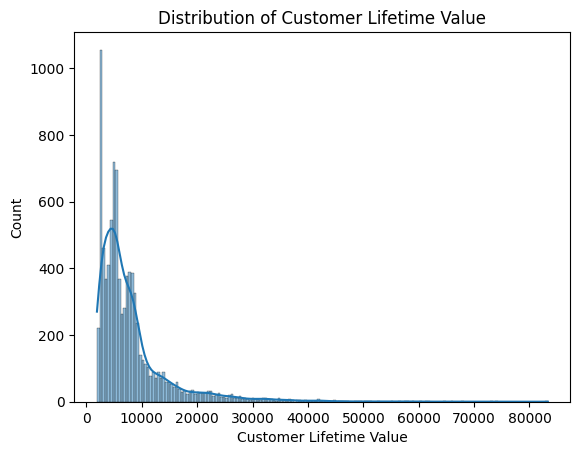

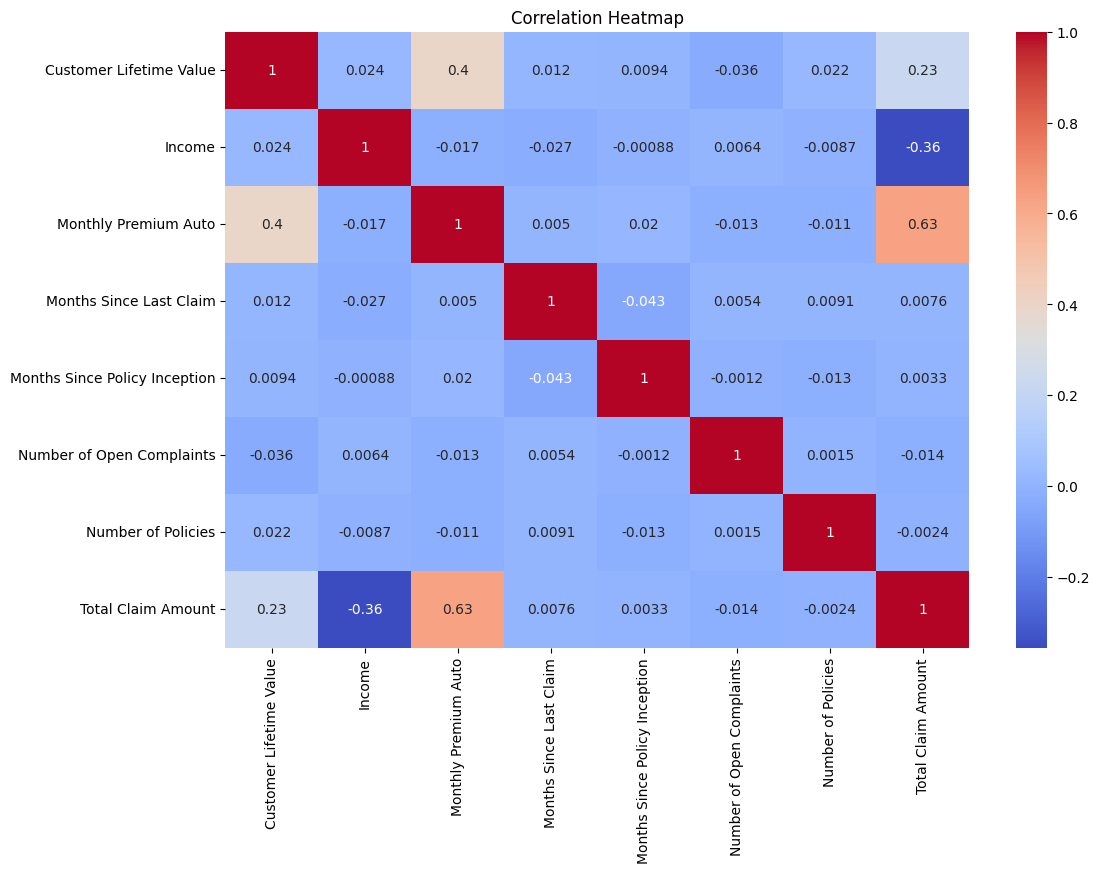

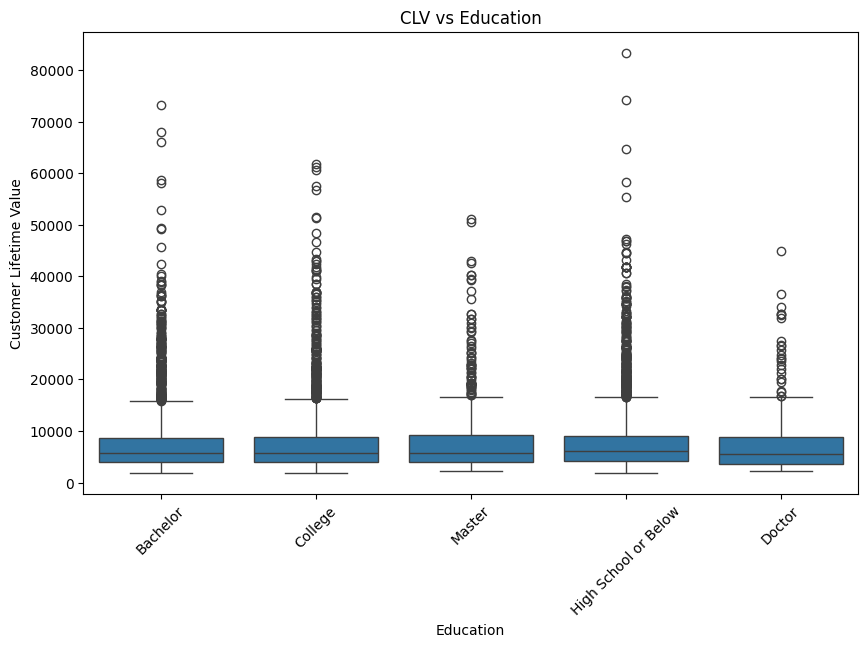

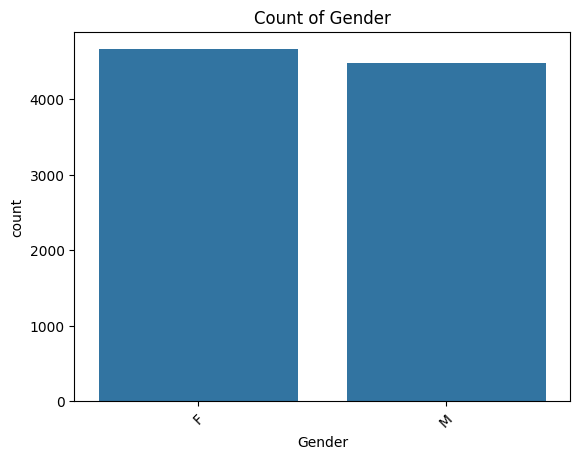

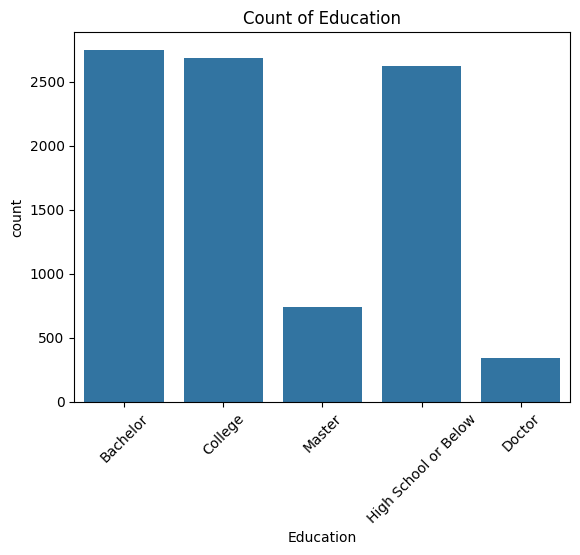

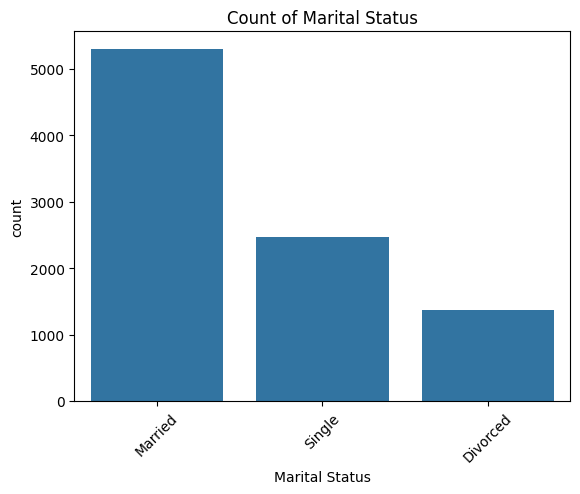

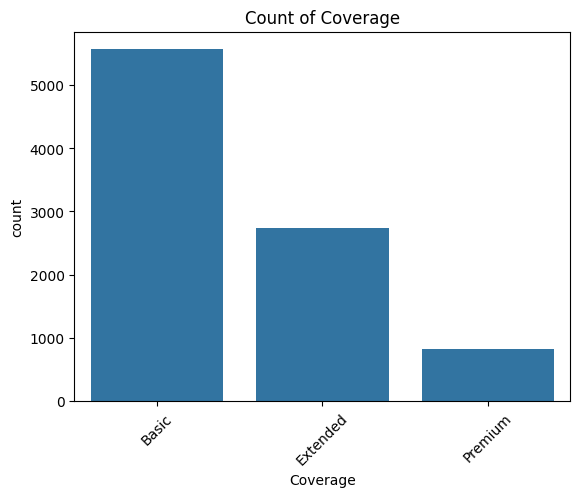

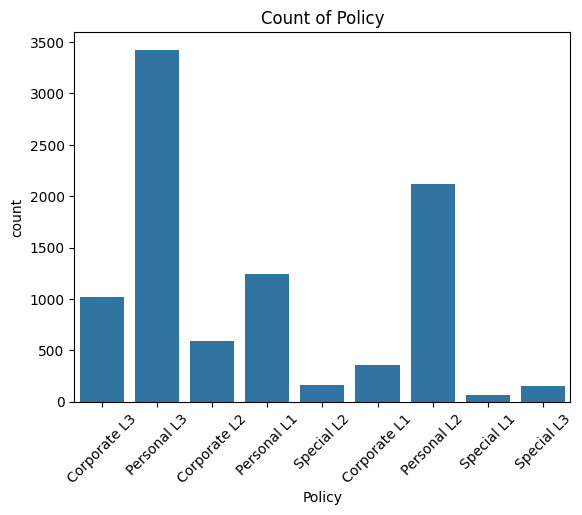

Fitting 3 folds for each of 43 candidates, totalling 129 fits
Best Parameters Found:
 {'max_depth': 17, 'max_features': None, 'min_samples_leaf': 3, 'min_samples_split': 8, 'n_estimators': 963}
 Mean Squared Error (MSE): 15631882.381168712
 R² Score: 0.6966811887487567


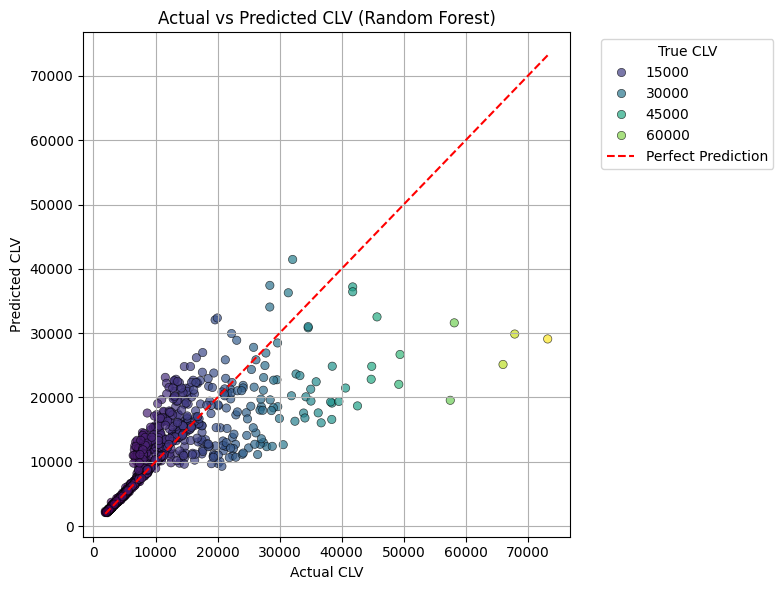

R² Score using Reloaded Model: 0.6966811887487567
🧪 Cross-Validation MSE (avg): 13825028.434598202


In [3]:
# First, I'm importing all the libraries I'll need for data analysis, preprocessing, modeling, and visualization.
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import randint
import joblib
import warnings
warnings.filterwarnings("ignore")

# Here, I'm loading the marketing customer value dataset.
df = pd.read_csv("WA_Fn-UseC_-Marketing-Customer-Value-Analysis.csv")

print("Shape of the dataset:", df.shape)
print(df.info())  # Info about columns and datatypes
print(df.describe())  # Summary statistics

#  checking if there are any missing values in the dataset.
print("Missing Values:\n", df.isnull().sum())

# Now I’m going to visualize the distribution of the target variable (Customer Lifetime Value).
sns.histplot(df['Customer Lifetime Value'], kde=True)
plt.title("Distribution of Customer Lifetime Value")
plt.show()


# Here Iam checking how the numerical features correlate with each other.
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()


# I am plotting how CLV varies with Education level to look for any patterns.
plt.figure(figsize=(10, 6))
sns.boxplot(x='Education', y='Customer Lifetime Value', data=df)
plt.title("CLV vs Education")
plt.xticks(rotation=45)
plt.show()

# There's definitely a visible variation in CLV across different education levels.

# Now I’m visualizing the distribution of some categorical features to understand the data composition.
cat_features = ['Gender', 'Education', 'Marital Status', 'Coverage', 'Policy']
for col in cat_features:
    sns.countplot(x=col, data=df)
    plt.title(f"Count of {col}")
    plt.xticks(rotation=45)
    plt.show()


# Here I'm dropping identifier and date columns since they don’t help in prediction.
df.drop(columns=['Customer', 'Effective To Date'], inplace=True)

# Encoding all categorical variables using LabelEncoder so that the model can process them.
cat_cols = df.select_dtypes(include='object').columns
le_dict = {}  # I'll store the encoders in case I need to inverse transform later
for col in cat_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    le_dict[col] = le

# Now I’m separating the features (X) and the target (y)
X = df.drop('Customer Lifetime Value', axis=1)
y = df['Customer Lifetime Value']

# Optionally, I could apply a log transformation here to reduce skewness, but I'm keeping it raw for now.
# y = np.log1p(y)

# I’m scaling the features using StandardScaler to bring all variables to the same scale.
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Splitting the dataset into training and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42)



# Here I’m defining the Random Forest model — a good starting point for regression tasks.
rf = RandomForestRegressor(random_state=42)

# Now I’m defining a hyperparameter space to tune the model.
param_dist = {
    'n_estimators': randint(100, 1000),  # Number of trees
    'max_depth': randint(3, 30),         # Maximum depth of the tree
    'min_samples_split': randint(2, 10), # Minimum samples to split an internal node
    'min_samples_leaf': randint(1, 10),  # Minimum samples for a leaf node
    'max_features': ['sqrt', 'log2', None]  # Number of features to consider for split
}

# I'm using RandomizedSearchCV for tuning — it's faster than GridSearchCV for large spaces.
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=43,  # Number of random combinations to try
    cv=3,  # 3-fold cross-validation
    scoring='neg_mean_squared_error',
    random_state=42,
    n_jobs=-1,  # Use all cores
    verbose=2
)

# Now I’m fitting the Random Forest with the training data and letting RandomizedSearch find the best parameters.
random_search.fit(X_train, y_train)

# Showing the best parameters found from tuning
print("Best Parameters Found:\n", random_search.best_params_)



# Using the best model from RandomizedSearch to make predictions on the test set.
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)

# Evaluating the model using MSE and R²
print(" Mean Squared Error (MSE):", mean_squared_error(y_test, y_pred))
print(" R² Score:", r2_score(y_test, y_pred))



# Here I am  plotting how the predicted CLV compares to the actual CLV
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred, hue=y_test, palette='viridis', alpha=0.7, edgecolor='k')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Perfect Prediction')
plt.xlabel("Actual CLV")
plt.ylabel("Predicted CLV")
plt.title("Actual vs Predicted CLV (Random Forest)")
plt.legend(title="True CLV", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()




# I’m saving the trained model to disk using joblib so I can reuse it later.
joblib.dump(best_model, "best_rf_model.pkl")

# Just to confirm, I’ll reload the model and test if it gives the same results.
loaded_model = joblib.load("best_rf_model.pkl")
y_loaded_pred = loaded_model.predict(X_test)

# Checking R² again after reloading
print("R² Score using Reloaded Model:", r2_score(y_test, y_loaded_pred))



# Lastly, I’m doing cross-validation across the full dataset to see how well the model generalizes.
cv_scores = cross_val_score(best_model, X_scaled, y, cv=5, scoring='neg_mean_squared_error')
print("🧪 Cross-Validation MSE (avg):", -np.mean(cv_scores))
